# Predicting Popularity of Political Reddit Posts

In this code, we will be predicting the popularity of political reddit posts based on the post content.

In [ ]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# install seaborn
%pip install seaborn

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print(spark.version)

3.4.0


In [2]:
df = spark.read.csv(f'df_ml.csv', header = True)

In [3]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [4]:
df.columns

['_c0',
 'subreddit',
 'author',
 'text',
 'num_comments',
 'score',
 'date',
 'sentiment',
 'is_biden',
 'is_trump',
 'id',
 'is_hunter',
 'is_border',
 'is_war',
 'is_israel',
 'is_harris',
 'is_indictment']

In [5]:
from pyspark.sql.functions import concat_ws, col, year, month, regexp_replace, when, lit, udf

clean = df \
    .withColumn('num_comments', col('num_comments').cast("integer")) \
    .withColumn('score', col('score').cast("integer")) \
    .withColumn('date', col('date').cast("date")) \
    .withColumn('is_biden', col('is_biden').cast("integer")) \
    .withColumn('is_trump', col('is_trump').cast("integer")) \
    .withColumn('is_hunter', col('is_hunter').cast("integer")) \
    .withColumn('is_border', col('is_border').cast("integer")) \
    .withColumn('is_war', col('is_war').cast("integer")) \
    .withColumn('is_israel', col('is_israel').cast("integer")) \
    .withColumn('is_harris', col('is_harris').cast("integer")) \
    .withColumn('is_indictment', col('is_indictment').cast("integer")) \
    .withColumn("year", year(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .withColumn("clean_text", regexp_replace(col("text"), "[^a-zA-Z0-9\s]", "")) \
    .withColumn("score_label",
                when(col("score") == 0, 0)
                .when(col("score") == 1, 1)
                .when((col("score") >= 2) & (col("score") < 10), 2)
                .when((col("score") >= 10) & (col("score") < 100), 3)
                .when((col("score") >= 100) & (col("score") < 1000), 4)
                .otherwise(5)
        ) \
    .drop(*['_c0', 'id', 'date'])

In [6]:
clean.show(1)

+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+--------------------+-----------+
| subreddit|            author|                text|num_comments|score|sentiment|is_biden|is_trump|is_hunter|is_border|is_war|is_israel|is_harris|is_indictment|year|month|          clean_text|score_label|
+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+--------------------+-----------+
|Republican|interestingfactoid| say her name   c...|           2|   12| positive|       1|       0|        0|        1|     0|        0|        0|            0|2024|    6| say her name   c...|          3|
+----------+------------------+--------------------+------------+-----+---------+--------+--------+---------+---------+------+---------+---------+-------------+----+-----+---------

In [7]:
clean.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_biden: integer (nullable = true)
 |-- is_trump: integer (nullable = true)
 |-- is_hunter: integer (nullable = true)
 |-- is_border: integer (nullable = true)
 |-- is_war: integer (nullable = true)
 |-- is_israel: integer (nullable = true)
 |-- is_harris: integer (nullable = true)
 |-- is_indictment: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- score_label: integer (nullable = false)



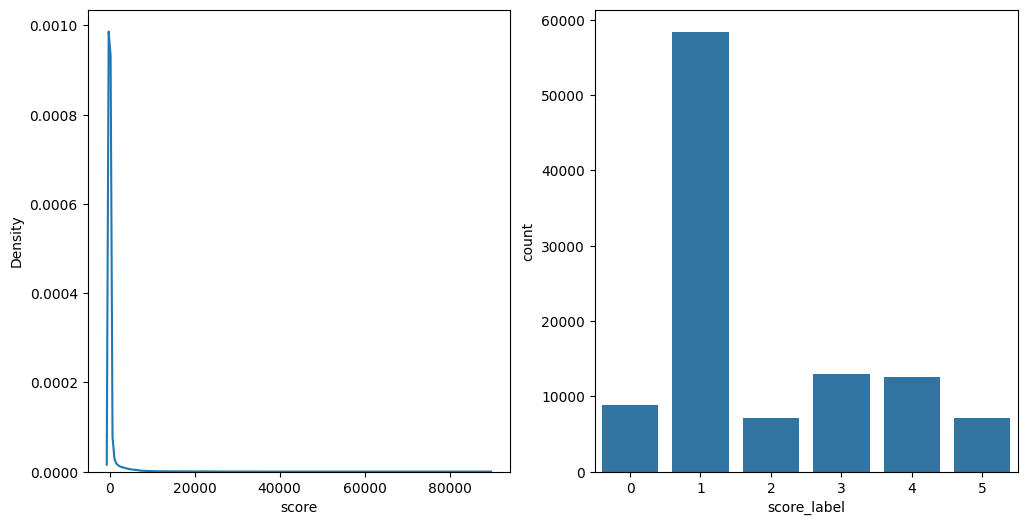

In [8]:
score_df = clean.select('score', 'score_label').toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(data=score_df, x='score', ax=ax[0])
sns.countplot(data=score_df, x='score_label', ax=ax[1])

plt.show()

In [9]:
# Convert strings to vector embeddings
from pyspark.ml.feature import HashingTF, Tokenizer, IDF, Normalizer, StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler, Word2Vec
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures", numFeatures=500)
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="tfidf")

subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_index")
subreddit_encoder = OneHotEncoder(inputCol="subreddit_index", outputCol="subreddit_vector")

author_indexer = StringIndexer(inputCol="author", outputCol="author_index")

sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")
sentiment_encoder = OneHotEncoder(inputCol="sentiment_index", outputCol="sentiment_vector")

# Normalize all input features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=[
        "tfidf", "num_comments", "subreddit_vector",
        "sentiment_vector", "year", "month", "is_biden", "is_trump", "is_hunter", 
        "is_border", "is_war", "is_israel", "is_harris",
        "is_indictment"
    ],
    outputCol="features",
)

# Build the pipeline
pipeline = Pipeline(
    stages=[
        tokenizer,
        hashingTF,
        idf,
        subreddit_indexer,
        subreddit_encoder,
        author_indexer,
        sentiment_indexer,
        sentiment_encoder,
        assembler,
        scaler
    ]
)

In [10]:
pipeline_model = pipeline.fit(clean)

In [11]:
modeling_df = pipeline_model.transform(clean)

In [12]:
# Split data into training, validation, and test sets
(train, test) = modeling_df.randomSplit([0.8, 0.2], seed=1989)

evaluator = MulticlassClassificationEvaluator(labelCol="score_label", predictionCol="prediction", metricName="accuracy")

In [13]:
train_score_df = train.select('score_label').toPandas()
test_score_df = test.select('score_label').toPandas()

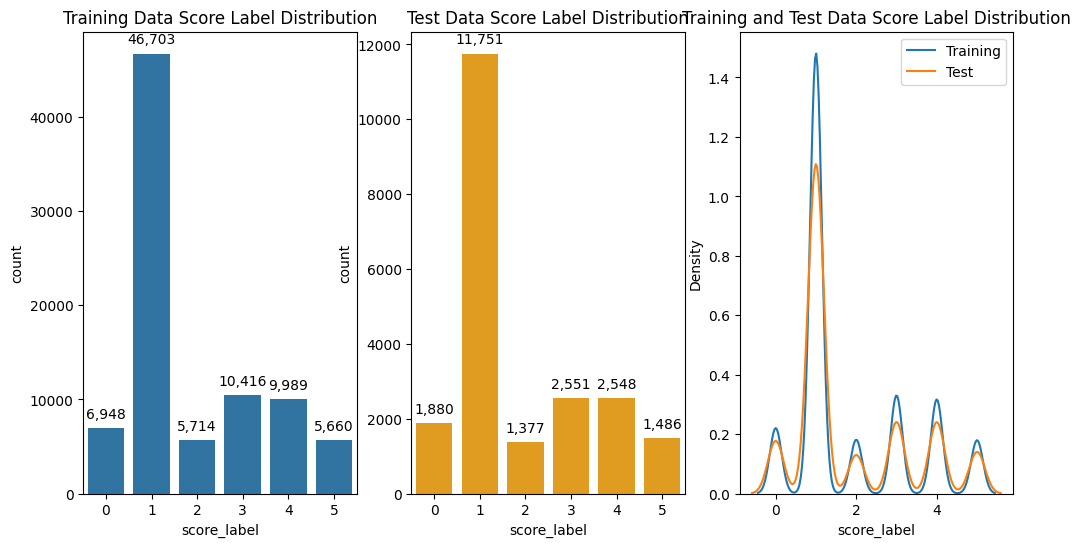

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

sns.countplot(data=train_score_df, x='score_label', ax=ax[0])
sns.countplot(data=test_score_df, x='score_label', ax=ax[1], color='orange')
# Write couts on top of bars
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for p in ax[1].patches:
    ax[1].annotate(f"{p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[0].set_title('Training Data Score Label Distribution')
ax[1].set_title('Test Data Score Label Distribution')

# Plot normalized score distribution for training and test
sns.kdeplot(data=train_score_df, x='score_label', ax=ax[2], label='Training')
sns.kdeplot(data=test_score_df, x='score_label', ax=ax[2], label='Test')

ax[2].set_title('Training and Test Data Score Label Distribution')
ax[2].legend()


plt.show()

In [15]:
# Get accuracy if all predictions were the most common class
from pyspark.sql.functions import lit

most_common_class = train.groupBy('score_label').count().orderBy('count', ascending=False).first()['score_label']
most_common_class

predictions = test.withColumn('prediction', lit(most_common_class).cast("double"))
acc = evaluator.evaluate(predictions)

print(f"Most common class accuracy (baseline model): {acc:.2%}")

Most common class accuracy (baseline model): 54.42%


### Logistic Regression

In [ ]:
lr = LogisticRegression(labelCol="score_label", featuresCol="scaled_features")

lr_model = lr.fit(train)
lr_preds = lr_model.transform(test)
lr_acc = evaluator.evaluate(lr_preds)
print(f"Lr Model Accuracy: {lr_acc:.2%}")

Lr Model Accuracy: 66.03%


In [41]:
# Hypertune logistic classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr = LogisticRegression(labelCol="score_label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_lr_model")

In [42]:
predictions = best_model.transform(test)
acc = evaluator.evaluate(predictions)

print(f"Best model accuracy: {acc:.2%}")

Best model accuracy: 66.03%


In [44]:
# Visualize cross validation results
import seaborn as sns
import pandas as pd

cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
# Extract hyperparameters
paramGrid = cvModel.getEstimatorParamMaps()

for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results

,accuracy,regParam,elasticNetParam
0,0.659948,0.00,0.0
1,0.659595,0.00,0.5
2,0.659830,0.00,1.0
3,0.594343,0.01,0.0
4,0.591157,0.01,0.5
5,0.597290,0.01,1.0
6,0.564071,0.10,0.0
7,0.548107,0.10,0.5
8,0.546689,0.10,1.0


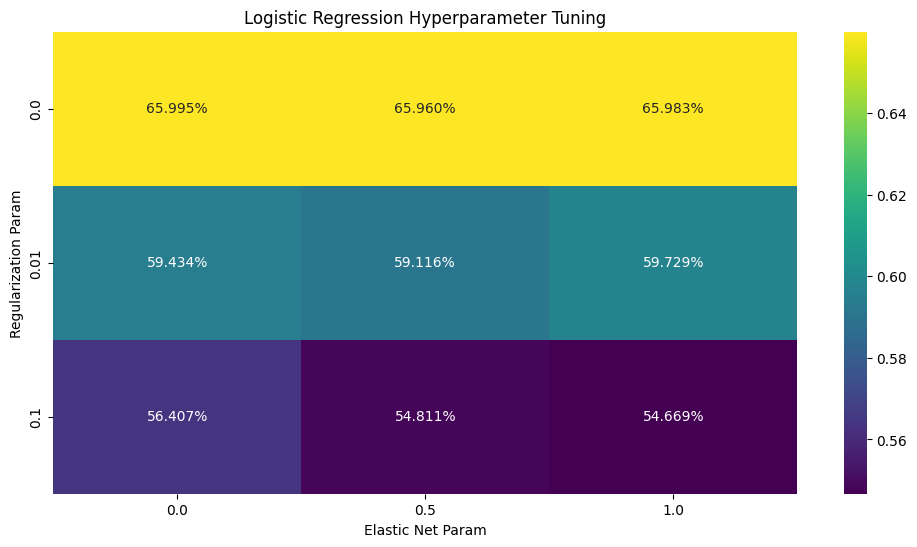

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

heatmap_data = cv_results.pivot(index="regParam", columns="elasticNetParam", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Logistic Regression Hyperparameter Tuning")

ax.set_xlabel("Elastic Net Param")
ax.set_ylabel("Regularization Param")

plt.show()

### Random Forest Classifier

In [ ]:
# Run basic Random Forest Classifier
rf = RandomForestClassifier(labelCol="score_label", featuresCol="scaled_features")

rf_model = rf.fit(train)
rf_preds = rf_model.transform(test)
rf_acc = evaluator.evaluate(rf_preds)

print(f"Random Forest Model Accuracy: {rf_acc:.2%}")

Random Forest Model Accuracy: 0.5457787245866716


In [16]:
# Hypertune Random Forest Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier(labelCol="score_label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 40]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_rf_model")

predictions = best_model.transform(test)
rf_best_acc = evaluator.evaluate(predictions)
print(f"Best Random Forest model accuracy: {rf_best_acc:.2%}")

Best Random Forest model accuracy: 67.05%


    accuracy  numTrees  maxDepth
0   0.549677      10.0       5.0
1   0.577928      10.0      10.0
2   0.634791      10.0      15.0
3   0.548642      20.0       5.0
4   0.586238      20.0      10.0
5   0.661503      20.0      15.0
6   0.548000      30.0       5.0
7   0.571344      30.0      10.0
8   0.651522      30.0      15.0
9   0.547813      40.0       5.0
10  0.563503      40.0      10.0
11  0.642420      40.0      15.0


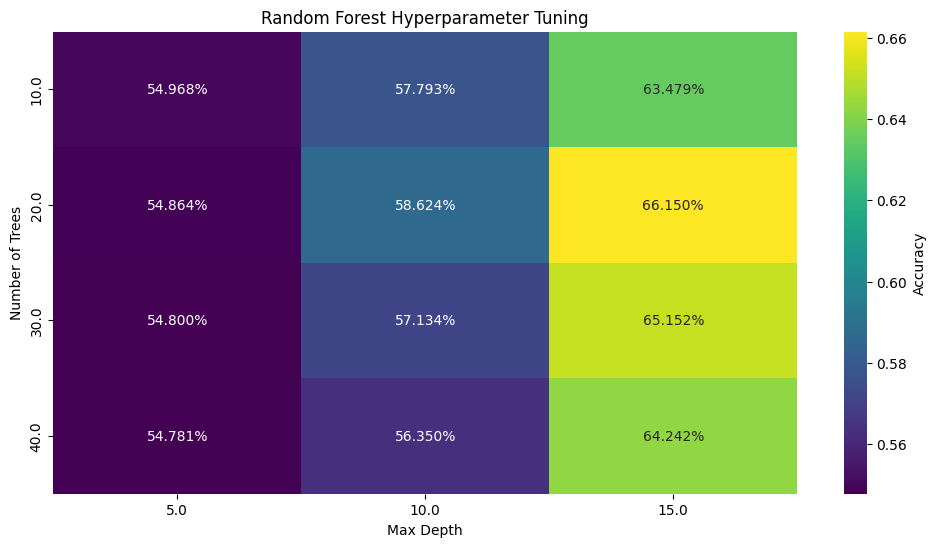

In [18]:
import seaborn as sns
import pandas as pd

cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
# Extract hyperparameters
paramGrid = cvModel.getEstimatorParamMaps()

for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("rf_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

heatmap_data = cv_results.pivot(index="numTrees", columns="maxDepth", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Random Forest Hyperparameter Tuning")

ax.set_xlabel("Max Depth")
ax.set_ylabel("Number of Trees")

ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

### Decision Tree Classifier

In [30]:
# Run basic Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="score_label", featuresCol="scaled_features")

dt_model = dt.fit(train)
dt_preds = dt_model.transform(test)
dt_acc = evaluator.evaluate(dt_preds)

print(f"Decision Tree Model Accuracy: {dt_acc:.2%}")

Decision Tree Model Accuracy: 71.62%


In [31]:
# Hypertune Decision Tree Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

dt = DecisionTreeClassifier(labelCol="score_label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_dt_model")

In [32]:
dt_best_preds = best_model.transform(test)
dt_best_acc = evaluator.evaluate(dt_best_preds)
print(f"Best Decision Tree model accuracy: {dt_best_acc:.2%}")

Best Decision Tree model accuracy: 73.62%


   accuracy  maxDepth  maxBins
0  0.715084       5.0     10.0
1  0.718104       5.0     20.0
2  0.716536       5.0     30.0
3  0.732248      10.0     10.0
4  0.734869      10.0     20.0
5  0.735234      10.0     30.0
6  0.722344      15.0     10.0
7  0.724874      15.0     20.0
8  0.726292      15.0     30.0


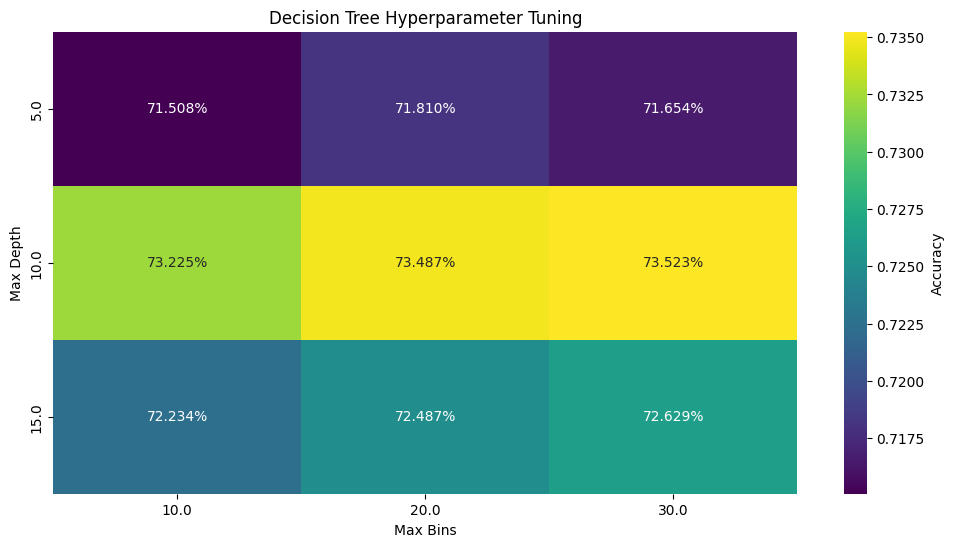

In [33]:
cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
paramGrid = cvModel.getEstimatorParamMaps()
for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("dt_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
heatmap_data = cv_results.pivot(index="maxDepth", columns="maxBins", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")
plt.title("Decision Tree Hyperparameter Tuning")
ax.set_xlabel("Max Bins")
ax.set_ylabel("Max Depth")
ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

### Naive Bayes Classifier

In [34]:
# Run basic Multinomial Naive Bayes Classifier
nb = NaiveBayes(labelCol="score_label", featuresCol="scaled_features")

nb_model = nb.fit(train)
nb_preds = nb_model.transform(test)
nb_acc = evaluator.evaluate(nb_preds)

print(f"Naive Bayes Model Accuracy: {nb_acc:.2%}")

Naive Bayes Model Accuracy: 41.80%


In [35]:
# Hypertune Naive Bayes Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

nb = NaiveBayes(labelCol="score_label", featuresCol="scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cvModel = crossval.fit(train)

best_model = cvModel.bestModel

# Save model with overwrite
best_model.write().overwrite().save("best_nb_model")

In [36]:
# Evaluate best model
nb_best_preds = best_model.transform(test)
nb_best_acc = evaluator.evaluate(nb_best_preds)
print(f"Best Naive Bayes model accuracy: {nb_best_acc:.2%}")

Best Naive Bayes model accuracy: 41.80%


   accuracy  smoothing
0  0.415490        0.0
1  0.415993        0.5
2  0.416309        1.0


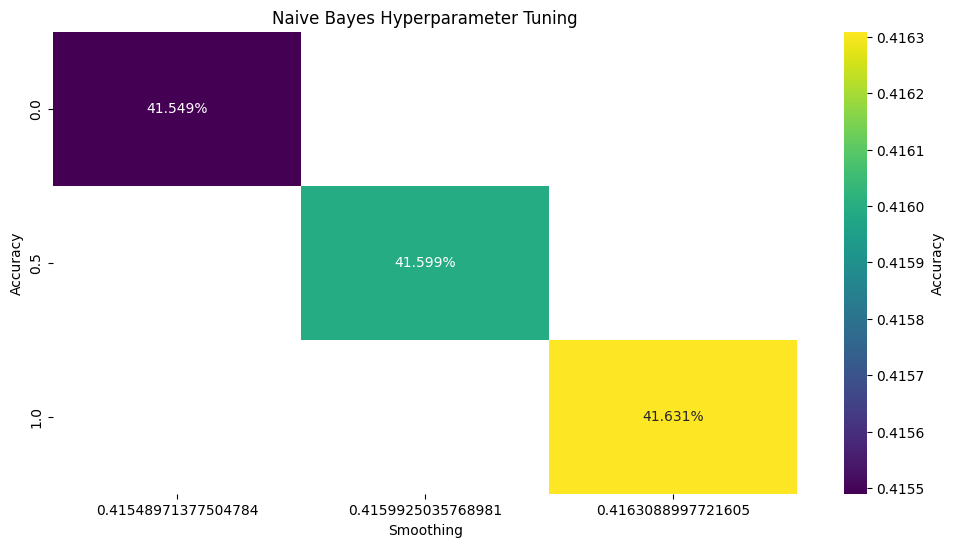

In [37]:
# Visualize cross validation results
cv_results = pd.DataFrame(cvModel.avgMetrics, columns=["accuracy"])
paramGrid = cvModel.getEstimatorParamMaps()
for i, params in enumerate(paramGrid):
    for key, value in params.items():
        cv_results.loc[i, key.name] = value

cv_results.to_csv("nb_cv_results.csv")
print(cv_results)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
heatmap_data = cv_results.pivot(index="smoothing", columns="accuracy", values="accuracy")

sns.heatmap(data=heatmap_data, annot=True, ax=ax, cmap="viridis", fmt=".3%")

plt.title("Naive Bayes Hyperparameter Tuning")
ax.set_xlabel("Smoothing")
ax.set_ylabel("Accuracy")
ax.collections[0].colorbar.set_label("Accuracy")

plt.show()

## Assessing Results

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
lr_cv_results = pd.read_csv("../../../data/models/popularity-pred/results/lr_cv_results.csv")
rf_cv_results = pd.read_csv("../../../data/models/popularity-pred/results/rf_cv_results.csv")
dt_cv_results = pd.read_csv("../../../data/models/popularity-pred/results/dt_cv_results.csv")
nb_cv_results = pd.read_csv("../../../data/models/popularity-pred/results/nb_cv_results.csv")

print("Logistic Regression Best Hyperparameters")
print(lr_cv_results.loc[lr_cv_results["accuracy"].idxmax()])
print("\nRandom Forest Best Hyperparameters")
print(rf_cv_results.loc[rf_cv_results["accuracy"].idxmax()])
print("\nDecision Tree Best Hyperparameters")
print(dt_cv_results.loc[dt_cv_results["accuracy"].idxmax()])
print("\nNaive Bayes Best Hyperparameters")
print(nb_cv_results.loc[nb_cv_results["accuracy"].idxmax()])

Logistic Regression Best Hyperparameters
Unnamed: 0         0.000000
accuracy           0.661411
regParam           0.000000
elasticNetParam    0.000000
Name: 0, dtype: float64

Random Forest Best Hyperparameters
Unnamed: 0     5.000000
accuracy       0.661503
numTrees      20.000000
maxDepth      15.000000
Name: 5, dtype: float64

Decision Tree Best Hyperparameters
Unnamed: 0     5.000000
accuracy       0.735234
maxDepth      10.000000
maxBins       30.000000
Name: 5, dtype: float64

Naive Bayes Best Hyperparameters
Unnamed: 0    2.000000
accuracy      0.416309
smoothing     1.000000
Name: 2, dtype: float64


In [16]:
# Load best models
best_lr = LogisticRegression(labelCol="score_label", featuresCol="scaled_features", regParam=0.0, elasticNetParam=0.0)
best_rf = RandomForestClassifier(labelCol="score_label", featuresCol="scaled_features", numTrees=20, maxDepth=15)
best_dt = DecisionTreeClassifier(labelCol="score_label", featuresCol="scaled_features", maxDepth=10, maxBins=30)
best_nb = NaiveBayes(labelCol="score_label", featuresCol="scaled_features", smoothing=1.0)

# Train best models
best_lr_model = best_lr.fit(train)
best_rf_model = best_rf.fit(train)
best_dt_model = best_dt.fit(train)
best_nb_model = best_nb.fit(train)

In [17]:
lr_preds = best_lr_model.transform(test)
rf_preds = best_rf_model.transform(test)
dt_preds = best_dt_model.transform(test)
nb_preds = best_nb_model.transform(test)

In [18]:
lr_preds.toPandas().to_csv("lr_preds.csv", index=False)
rf_preds.toPandas().to_csv("rf_preds.csv", index=False)
dt_preds.toPandas().to_csv("dt_preds.csv", index=False)
nb_preds.toPandas().to_csv("nb_preds.csv", index=False)

In [1]:
import pandas as pd

lr_pred_df = pd.read_csv("../../../data/models/popularity-pred/results/lr_preds.csv")
rf_pred_df = pd.read_csv("../../../data/models/popularity-pred/results/rf_preds.csv")
dt_pred_df = pd.read_csv("../../../data/models/popularity-pred/results/dt_preds.csv")
nb_pred_df = pd.read_csv("../../../data/models/popularity-pred/results/nb_preds.csv")

In [2]:
lr_pred_df.rename(columns={"prediction": "lr_prediction", "rawPrediction": "lr_rawPrediction", "probability": "lr_probability"}, inplace=True)
rf_pred_df.rename(columns={"prediction": "rf_prediction", "rawPrediction": "rf_rawPrediction", "probability": "rf_probability"}, inplace=True)
dt_pred_df.rename(columns={"prediction": "dt_prediction", "rawPrediction": "dt_rawPrediction", "probability": "dt_probability"}, inplace=True)
nb_pred_df.rename(columns={"prediction": "nb_prediction", "rawPrediction": "nb_rawPrediction", "probability": "nb_probability"}, inplace=True)

In [3]:
# Combine all predictions (all rows match exactly except for the prediction columns)
combined_preds = pd.concat([lr_pred_df, rf_pred_df, dt_pred_df, nb_pred_df], axis=1)

In [4]:
# Select only the columns we want to keep
combined_preds = combined_preds[[
    "score_label", "lr_prediction", "lr_probability", "rf_prediction", "rf_probability",
    "dt_prediction", "dt_probability", "nb_prediction", "nb_probability"
]]

In [5]:
combined_preds = combined_preds.loc[:, ~combined_preds.columns.duplicated()]

In [6]:
combined_preds.head()

,score_label,lr_prediction,lr_probability,rf_prediction,rf_probability,dt_prediction,dt_probability,nb_prediction,nb_probability
0,1,1.0,"[0.011641569771396873,0.9609607893558143,0.003...",1.0,"[0.04002815462289438,0.8187006578808174,0.0444...",1.0,"[0.022717711400925537,0.9541438788388725,0.011...",1.0,"[4.29806242822294e-16,0.9999999999999996,2.034..."
1,1,1.0,"[0.004055834568518266,0.9814555405047933,0.002...",1.0,"[0.03316385810725682,0.8419754747410693,0.0324...",1.0,"[0.002500416736122687,0.9923320553425571,0.003...",1.0,"[2.992587023948116e-15,0.9999999999999967,8.17..."
2,0,1.0,"[0.04020217967144467,0.8346653782026028,0.0153...",1.0,"[0.03541520234567736,0.814934229783225,0.04828...",1.0,"[0.022717711400925537,0.9541438788388725,0.011...",1.0,"[1.5241062783441154e-14,0.999999999999948,3.61..."
3,1,1.0,"[0.034625854566348424,0.9035598764813589,0.004...",1.0,"[0.09264285134954084,0.6822954803944214,0.0668...",1.0,"[0.08088888888888889,0.9031111111111111,0.0088...",1.0,"[2.3640618720816073e-07,0.9999997635789458,1.1..."
4,1,1.0,"[0.017447623618294644,0.95787528063981,0.00288...",1.0,"[0.03826134417351413,0.8038403881956888,0.0424...",1.0,"[0.033384146341463417,0.9454268292682927,0.016...",1.0,"[1.4599187155292677e-16,0.9999999999999998,1.0..."


In [7]:
# Convert all prediction columns to integers
combined_preds["lr_prediction"] = combined_preds["lr_prediction"].astype(int)
combined_preds["rf_prediction"] = combined_preds["rf_prediction"].astype(int)
combined_preds["dt_prediction"] = combined_preds["dt_prediction"].astype(int)
combined_preds["nb_prediction"] = combined_preds["nb_prediction"].astype(int)

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
print("Logistic Regression Classification Report")
print(classification_report(combined_preds["score_label"], combined_preds["lr_prediction"]))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.42      0.15      0.22      1880
           1       0.69      0.97      0.81     11751
           2       0.14      0.01      0.01      1377
           3       0.50      0.20      0.29      2551
           4       0.53      0.42      0.47      2548
           5       0.77      0.64      0.70      1486

    accuracy                           0.66     21593
   macro avg       0.51      0.40      0.42     21593
weighted avg       0.60      0.66      0.60     21593



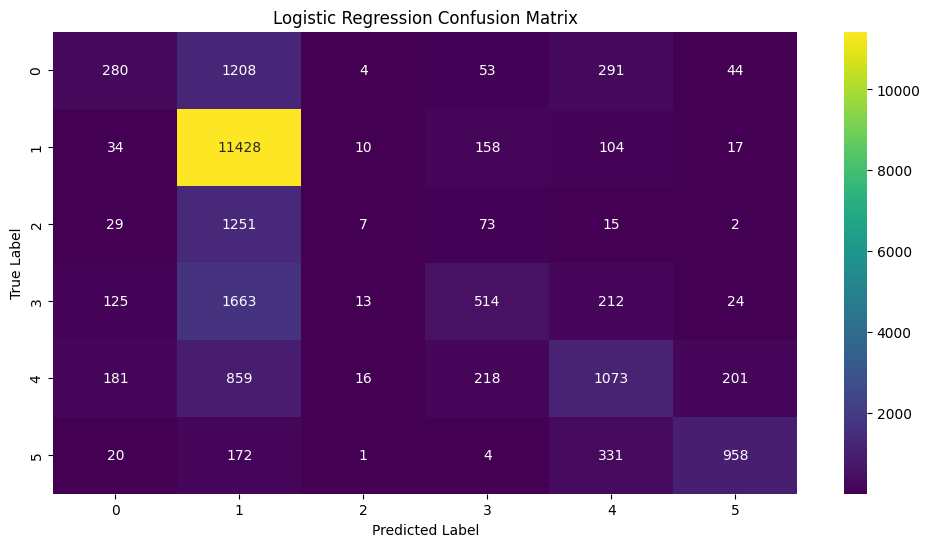

In [9]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

lr_confusion_matrix = confusion_matrix(combined_preds["score_label"], combined_preds["lr_prediction"])

import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(lr_confusion_matrix, annot=True, ax=ax, cmap="viridis", fmt=".0f")

plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [10]:
print("Random Forest Classification Report")
print(classification_report(combined_preds["score_label"], combined_preds["rf_prediction"]))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.52      0.07      0.12      1880
           1       0.64      0.99      0.78     11751
           2       0.64      0.01      0.01      1377
           3       0.61      0.26      0.36      2551
           4       0.53      0.31      0.39      2548
           5       0.85      0.31      0.45      1486

    accuracy                           0.63     21593
   macro avg       0.63      0.32      0.35     21593
weighted avg       0.63      0.63      0.55     21593



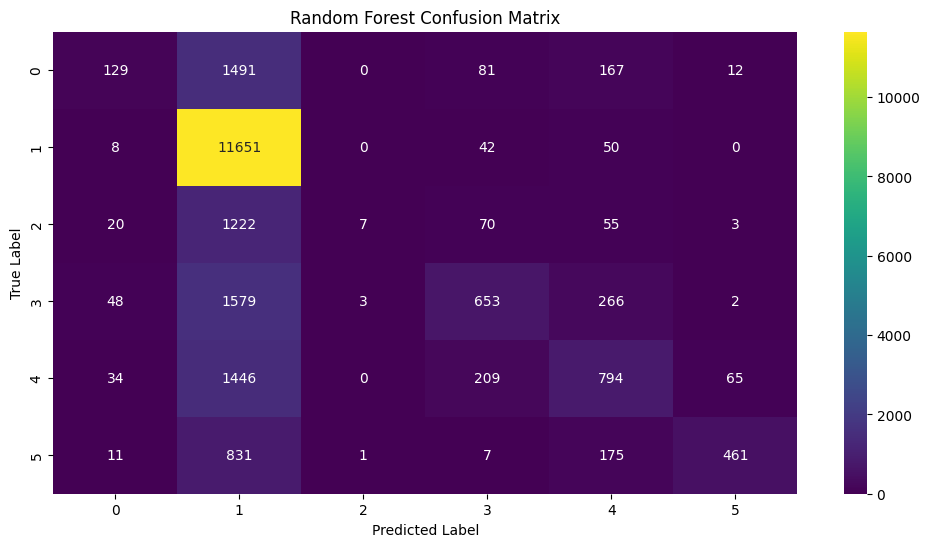

In [11]:
# Plot confusion matrix
rf_confusion_matrix = confusion_matrix(combined_preds["score_label"], combined_preds["rf_prediction"])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(rf_confusion_matrix, annot=True, ax=ax, cmap="viridis", fmt=".0f")

plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [12]:
print("Decision Tree Classification Report")
print(classification_report(combined_preds["score_label"], combined_preds["dt_prediction"]))

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.44      0.34      0.38      1880
           1       0.85      0.95      0.90     11751
           2       0.43      0.22      0.29      1377
           3       0.54      0.49      0.51      2551
           4       0.60      0.59      0.60      2548
           5       0.75      0.68      0.72      1486

    accuracy                           0.74     21593
   macro avg       0.60      0.55      0.57     21593
weighted avg       0.71      0.74      0.72     21593



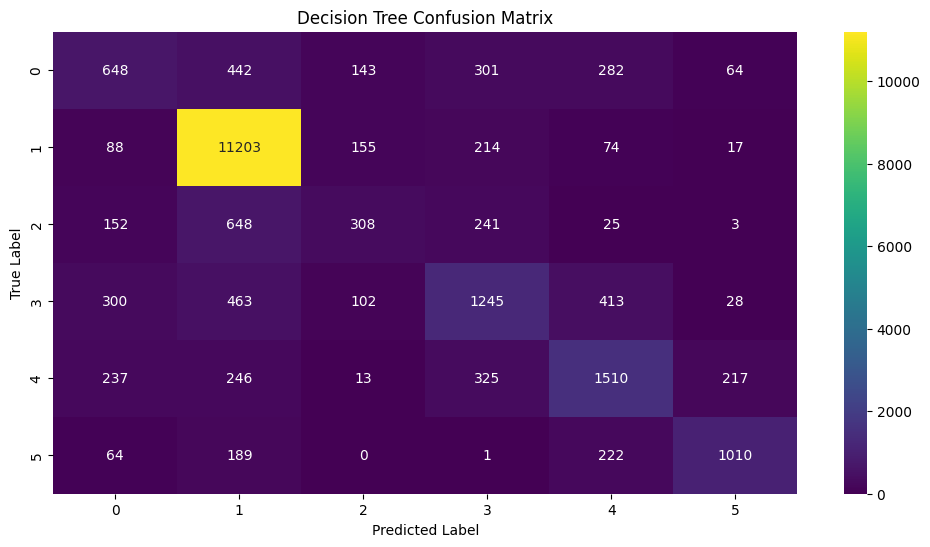

In [13]:
# Plot confusion matrix
dt_confusion_matrix = confusion_matrix(combined_preds["score_label"], combined_preds["dt_prediction"])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(dt_confusion_matrix, annot=True, ax=ax, cmap="viridis", fmt=".0f")

plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [14]:
print("Naive Bayes Classification Report")
print(classification_report(combined_preds["score_label"], combined_preds["nb_prediction"]))

Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.17      0.20      0.18      1880
           1       0.64      0.58      0.61     11751
           2       0.11      0.21      0.15      1377
           3       0.25      0.18      0.21      2551
           4       0.19      0.15      0.17      2548
           5       0.31      0.47      0.37      1486

    accuracy                           0.42     21593
   macro avg       0.28      0.30      0.28     21593
weighted avg       0.44      0.42      0.43     21593



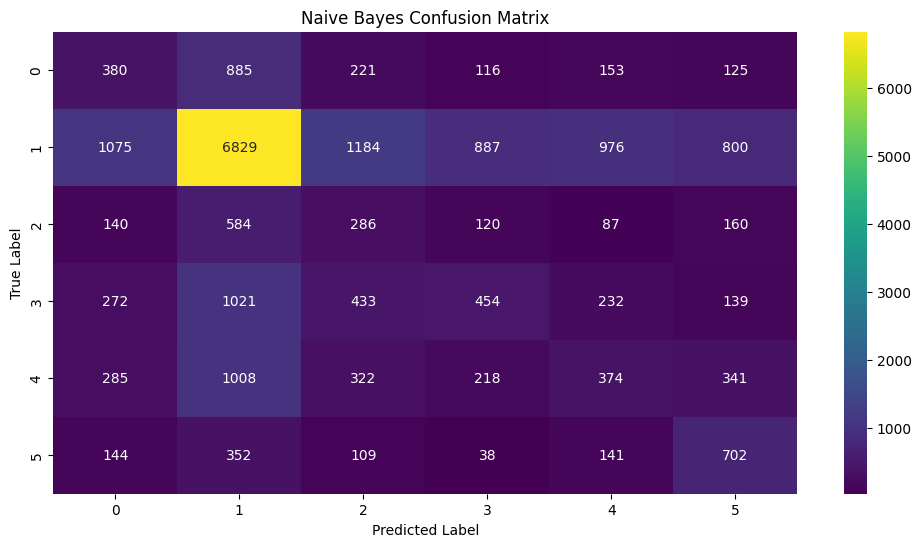

In [15]:
# Plot confusion matrix

nb_confusion_matrix = confusion_matrix(combined_preds["score_label"], combined_preds["nb_prediction"])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.heatmap(nb_confusion_matrix, annot=True, ax=ax, cmap="viridis", fmt=".0f")

plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

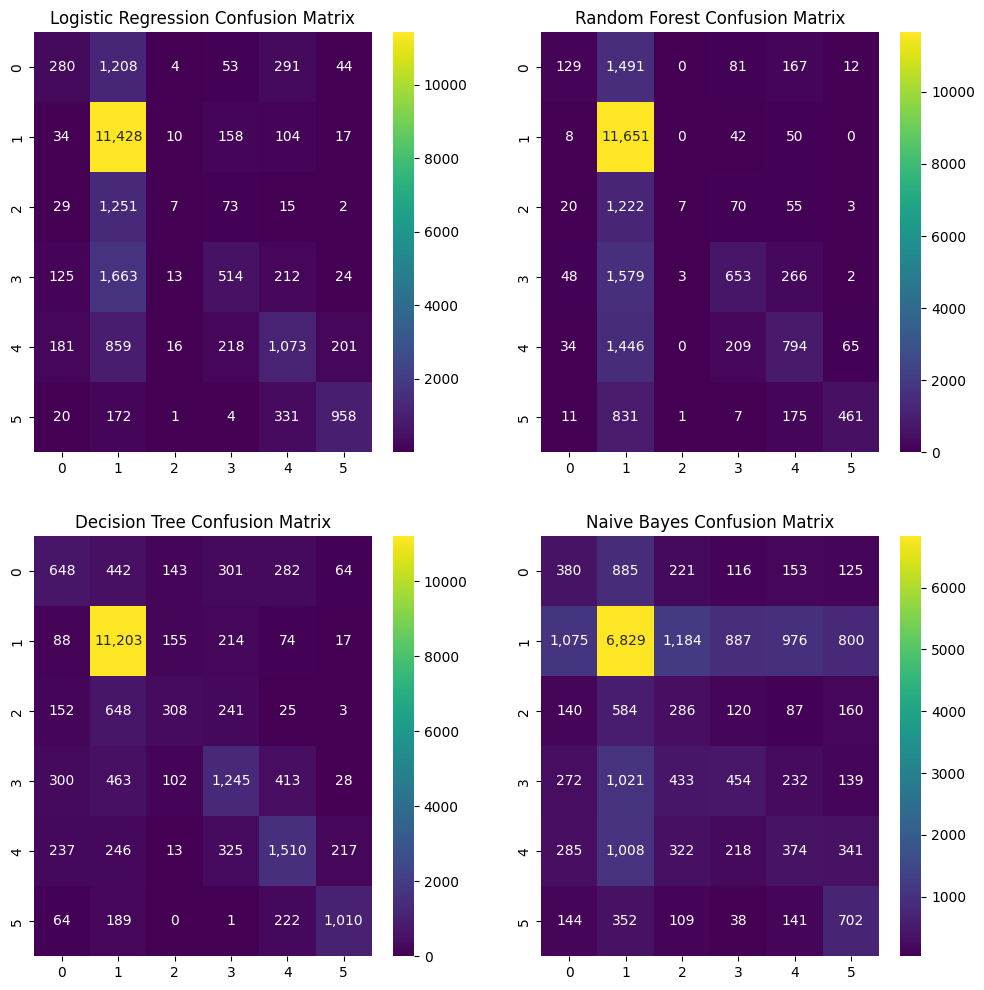

In [16]:
# Plot all confusion matrices

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(lr_confusion_matrix, annot=True, ax=ax[0, 0], cmap="viridis", fmt=",.0f")
sns.heatmap(rf_confusion_matrix, annot=True, ax=ax[0, 1], cmap="viridis", fmt=",.0f")
sns.heatmap(dt_confusion_matrix, annot=True, ax=ax[1, 0], cmap="viridis", fmt=",.0f")
sns.heatmap(nb_confusion_matrix, annot=True, ax=ax[1, 1], cmap="viridis", fmt=",.0f")

ax[0, 0].set_title("Logistic Regression Confusion Matrix")
ax[0, 1].set_title("Random Forest Confusion Matrix")
ax[1, 0].set_title("Decision Tree Confusion Matrix")
ax[1, 1].set_title("Naive Bayes Confusion Matrix")

plt.show()

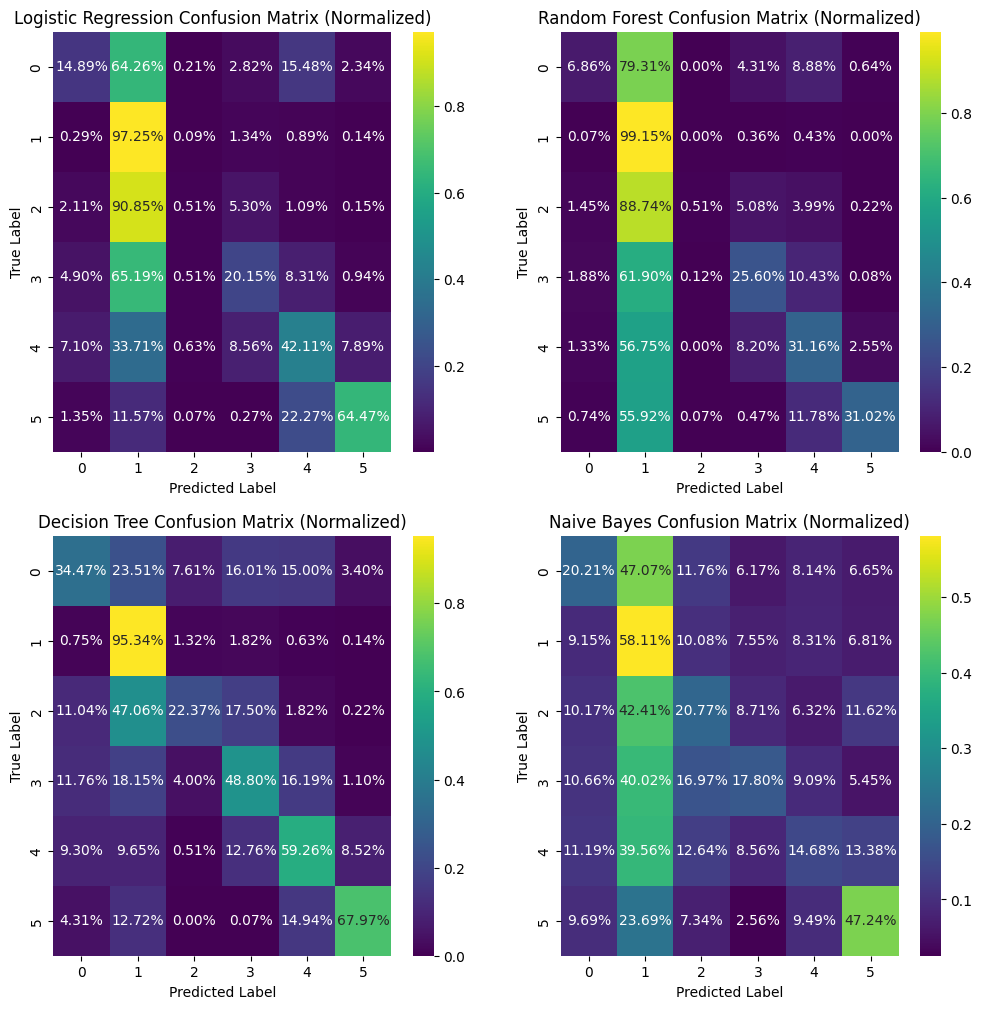

In [17]:
# Row-wise normalization of confusion matrices
lr_confusion_matrix_norm = lr_confusion_matrix / lr_confusion_matrix.sum(axis=1)[:, None]
rf_confusion_matrix_norm = rf_confusion_matrix / rf_confusion_matrix.sum(axis=1)[:, None]
dt_confusion_matrix_norm = dt_confusion_matrix / dt_confusion_matrix.sum(axis=1)[:, None]
nb_confusion_matrix_norm = nb_confusion_matrix / nb_confusion_matrix.sum(axis=1)[:, None]

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(lr_confusion_matrix_norm, annot=True, ax=ax[0, 0], cmap="viridis", fmt=".2%")
sns.heatmap(rf_confusion_matrix_norm, annot=True, ax=ax[0, 1], cmap="viridis", fmt=".2%")
sns.heatmap(dt_confusion_matrix_norm, annot=True, ax=ax[1, 0], cmap="viridis", fmt=".2%")
sns.heatmap(nb_confusion_matrix_norm, annot=True, ax=ax[1, 1], cmap="viridis", fmt=".2%")

ax[0, 0].set_title("Logistic Regression Confusion Matrix (Normalized)")
ax[0, 1].set_title("Random Forest Confusion Matrix (Normalized)")
ax[1, 0].set_title("Decision Tree Confusion Matrix (Normalized)")
ax[1, 1].set_title("Naive Bayes Confusion Matrix (Normalized)")

# Set axis labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Predicted Label")
        ax[i, j].set_ylabel("True Label")

plt.show()

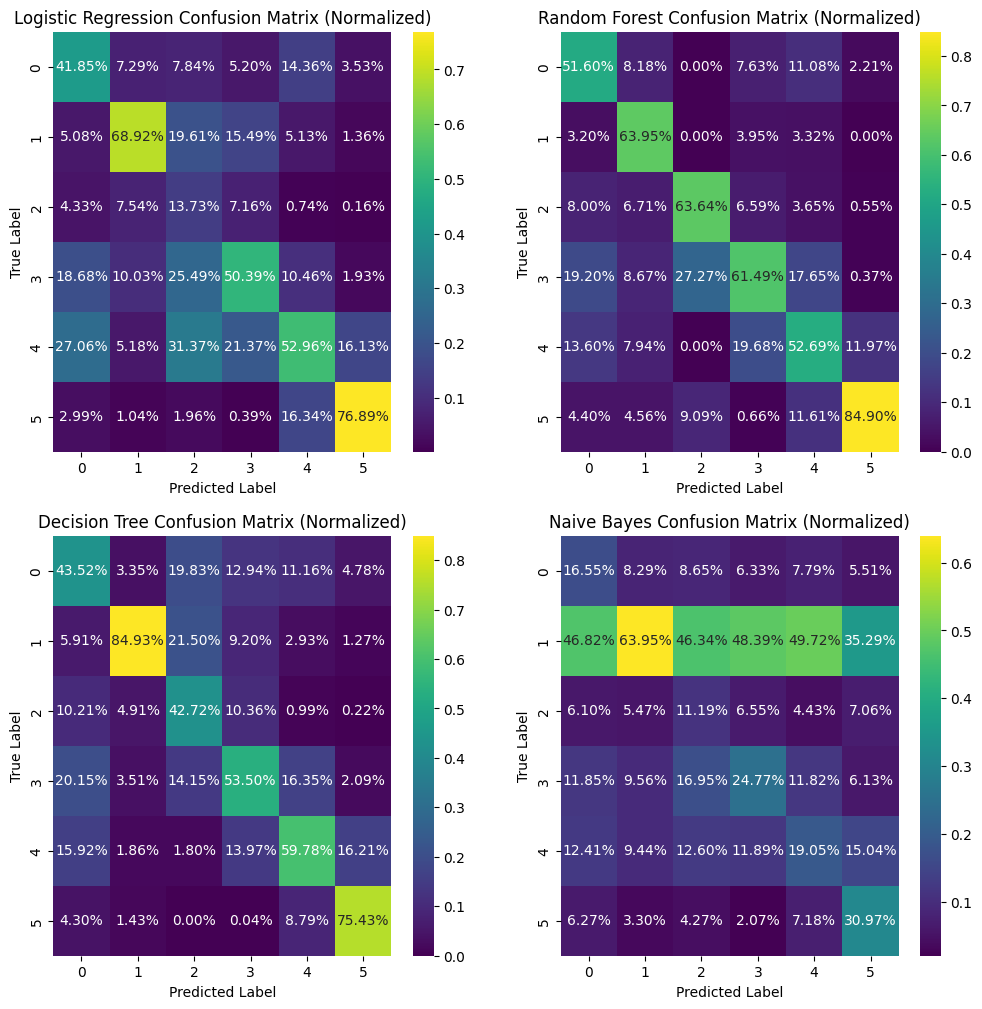

In [18]:
# # Column-wise normalization of confusion matrices
lr_confusion_matrix_norm = lr_confusion_matrix / lr_confusion_matrix.sum(axis=0)
rf_confusion_matrix_norm = rf_confusion_matrix / rf_confusion_matrix.sum(axis=0)
dt_confusion_matrix_norm = dt_confusion_matrix / dt_confusion_matrix.sum(axis=0)
nb_confusion_matrix_norm = nb_confusion_matrix / nb_confusion_matrix.sum(axis=0)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(lr_confusion_matrix_norm, annot=True, ax=ax[0, 0], cmap="viridis", fmt=".2%")
sns.heatmap(rf_confusion_matrix_norm, annot=True, ax=ax[0, 1], cmap="viridis", fmt=".2%")
sns.heatmap(dt_confusion_matrix_norm, annot=True, ax=ax[1, 0], cmap="viridis", fmt=".2%")
sns.heatmap(nb_confusion_matrix_norm, annot=True, ax=ax[1, 1], cmap="viridis", fmt=".2%")

ax[0, 0].set_title("Logistic Regression Confusion Matrix (Normalized)")
ax[0, 1].set_title("Random Forest Confusion Matrix (Normalized)")
ax[1, 0].set_title("Decision Tree Confusion Matrix (Normalized)")
ax[1, 1].set_title("Naive Bayes Confusion Matrix (Normalized)")

# Set axis labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Predicted Label")
        ax[i, j].set_ylabel("True Label")

plt.show()

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import ast

combined_preds['lr_probability'] = combined_preds['lr_probability'].apply(ast.literal_eval)
combined_preds['rf_probability'] = combined_preds['rf_probability'].apply(ast.literal_eval)
combined_preds['dt_probability'] = combined_preds['dt_probability'].apply(ast.literal_eval)
combined_preds['nb_probability'] = combined_preds['nb_probability'].apply(ast.literal_eval)

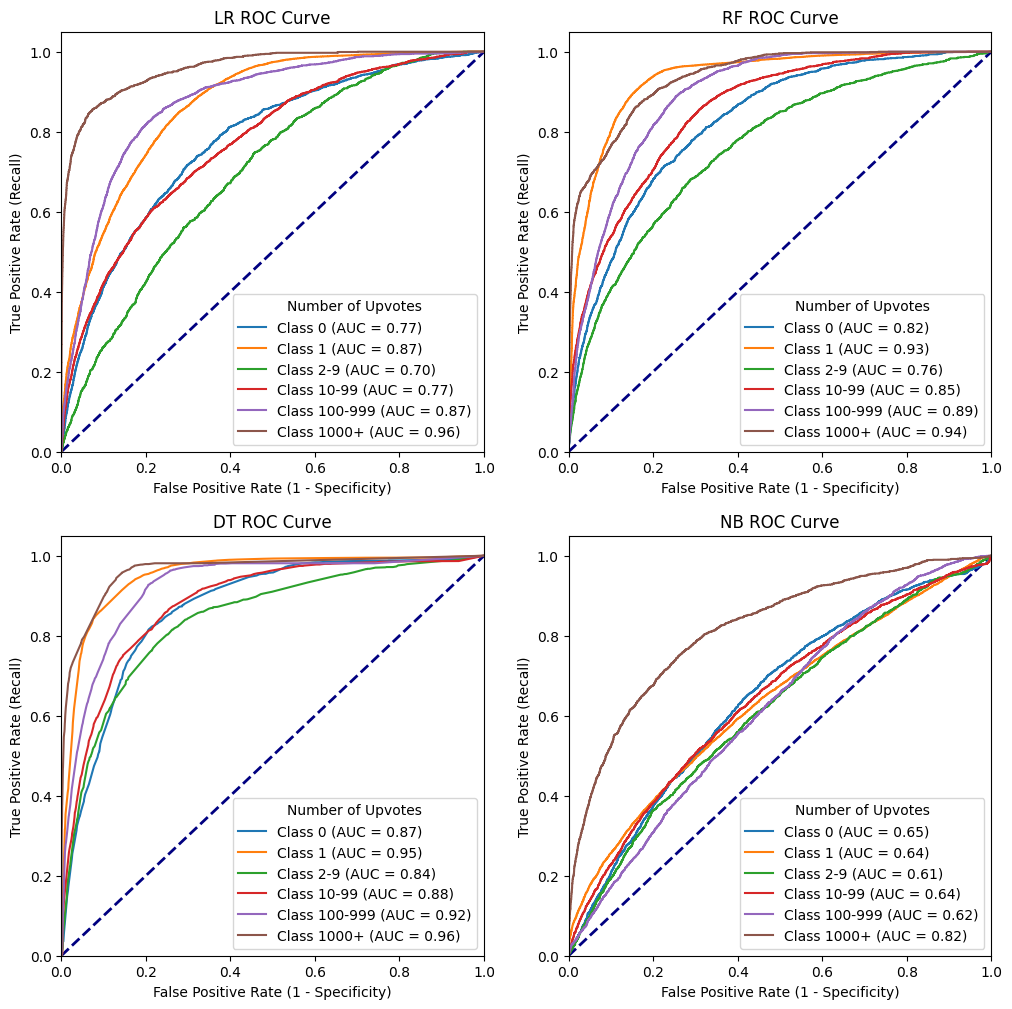

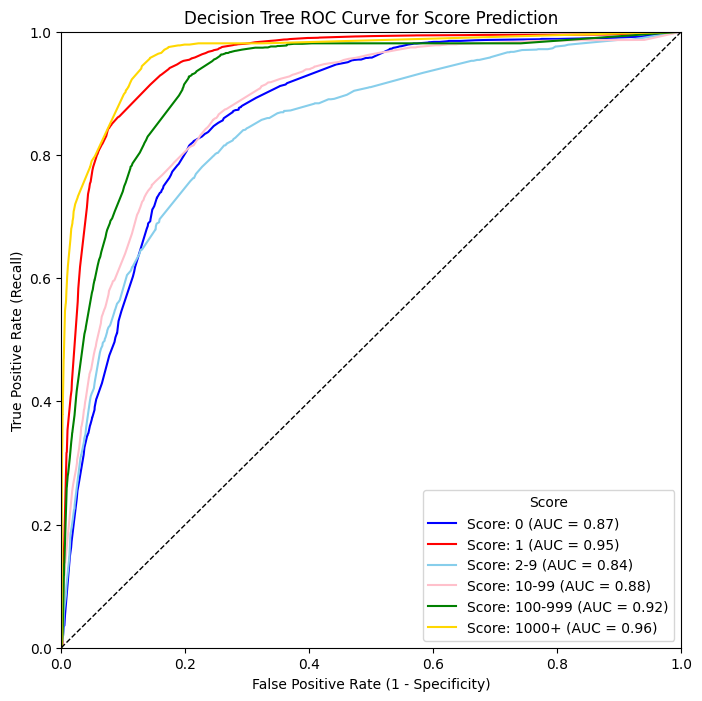

In [20]:
# Plot ROC curves
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

y_true = label_binarize(combined_preds["score_label"], classes=[0, 1, 2, 3, 4, 5])
lr_probs = np.array(combined_preds["lr_probability"].tolist())
rf_probs = np.array(combined_preds["rf_probability"].tolist())
dt_probs = np.array(combined_preds["dt_probability"].tolist())
nb_probs = np.array(combined_preds["nb_probability"].tolist())

fpr = dict()
tpr = dict()
roc_auc = dict()

models = ["lr", "rf", "dt", "nb"]
probs = [lr_probs, rf_probs, dt_probs, nb_probs]
class_names =['0', '1', '2-9', '10-99', '100-999', '1000+']

for i, model in enumerate(models):

    ax[i // 2, i % 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i // 2, i % 2].set_xlim([0.0, 1.0])
    ax[i // 2, i % 2].set_ylim([0.0, 1.05])

    fpr[model] = dict()
    tpr[model] = dict()
    roc_auc[model] = dict()
    for j in range(6):
        fpr[model][j], tpr[model][j], _ = roc_curve(y_true[:, j], probs[i][:, j])
        roc_auc[model][j] = roc_auc_score(y_true[:, j], probs[i][:, j])
        ax[i // 2, i % 2].plot(fpr[model][j], tpr[model][j], label=f'Class {class_names[j]} (AUC = {roc_auc[model][j]:.2f})')

    ax[i // 2, i % 2].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[i // 2, i % 2].set_ylabel('True Positive Rate (Recall)')

    ax[i // 2, i % 2].set_title(f"{model.upper()} ROC Curve")
    ax[i // 2, i % 2].legend(title="Number of Upvotes")

plt.show()

# Plot DT ROC curve
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

colors = ['blue', 'red', 'skyblue', 'pink', 'green', 'gold']
for j in range(6):
    fpr, tpr, _ = roc_curve(y_true[:, j], dt_probs[:, j])
    roc_auc = roc_auc_score(y_true[:, j], dt_probs[:, j])
    ax.plot(fpr, tpr, label=f'Score: {class_names[j]} (AUC = {roc_auc:.2f})', color=colors[j])

ax.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Recall)')

ax.set_title("Decision Tree ROC Curve for Score Prediction")
ax.legend(title="Score")

plt.show()

fig.savefig("roc_curve_dt_score.png", bbox_inches="tight", dpi=300)


In [21]:
# Make table of AUC scores
auc_scores = pd.DataFrame(index=class_names, columns=models)

for i, model in enumerate(models):
    for j in range(6):
        auc_scores.loc[class_names[j], model] = roc_auc[model][j]

auc_scores
auc_scores.to_csv("auc_scores.csv")

IndexError: invalid index to scalar variable.

In [22]:
# Make table of classification reports
from sklearn.metrics import classification_report

precisions = pd.DataFrame(index=class_names, columns=models)
recalls = pd.DataFrame(index=class_names, columns=models)
f1_scores = pd.DataFrame(index=class_names, columns=models)
supports = pd.DataFrame(index=class_names, columns=models)
overall_metrics = pd.DataFrame(index=["accuracy", "precision", "recall", "f1-score", "support"], columns=models)

for model in models:
    preds = combined_preds[f"{model}_prediction"]
    report = classification_report(combined_preds["score_label"], preds, output_dict=True)
    for j in range(6):
        f1_scores.loc[class_names[j], model] = report[str(j)]["f1-score"]
        precisions.loc[class_names[j], model] = report[str(j)]["precision"]
        recalls.loc[class_names[j], model] = report[str(j)]["recall"]
        supports.loc[class_names[j], model] = report[str(j)]["support"]
    overall_metrics.loc["accuracy", model] = report["accuracy"]
    overall_metrics.loc["precision", model] = report["macro avg"]["precision"]
    overall_metrics.loc["recall", model] = report["macro avg"]["recall"]
    overall_metrics.loc["f1-score", model] = report["macro avg"]["f1-score"]
    overall_metrics.loc["support", model] = report["macro avg"]["support"]

f1_scores.to_csv("f1_scores.csv")
precisions.to_csv("precisions.csv")
recalls.to_csv("recalls.csv")
supports.to_csv("supports.csv")
overall_metrics.to_csv("overall_metrics.csv")

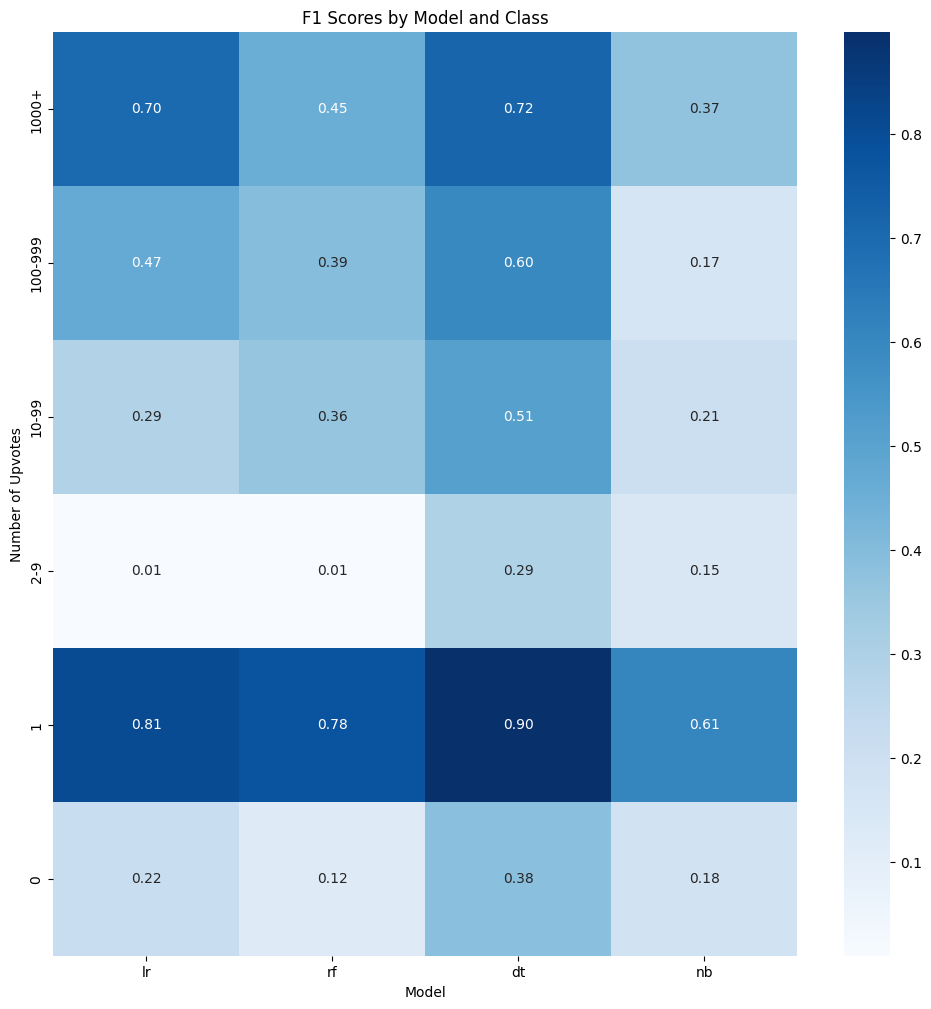

In [139]:
# Plot F1 scores
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.heatmap(f1_scores.astype(float), annot=True, ax=ax, cmap="Blues", fmt=".2f")

plt.title("F1 Scores by Model and Class")
plt.xlabel("Model")
plt.ylabel("Number of Upvotes")

# Reverse y-axis
plt.gca().invert_yaxis()

plt.show()

In [142]:
dt_feature_importances

SparseVector(521, {0: 0.0007, 1: 0.0002, 2: 0.0002, 3: 0.0001, 4: 0.0001, 5: 0.0002, 7: 0.0004, 8: 0.0001, 9: 0.0, 10: 0.0, 11: 0.0002, 12: 0.0002, 13: 0.0002, 15: 0.0002, 16: 0.0001, 17: 0.0014, 19: 0.0002, 20: 0.0002, 22: 0.0002, 23: 0.0001, 24: 0.0001, 26: 0.0006, 29: 0.0001, 30: 0.0002, 31: 0.0001, 32: 0.0004, 33: 0.0001, 34: 0.0001, 35: 0.0017, 37: 0.0003, 38: 0.0004, 39: 0.0001, 40: 0.0, 41: 0.0001, 42: 0.0001, 43: 0.0002, 44: 0.0002, 45: 0.0002, 47: 0.0001, 48: 0.0001, 49: 0.0002, 50: 0.0001, 53: 0.0001, 55: 0.0001, 57: 0.0002, 58: 0.0001, 59: 0.0001, 62: 0.0003, 63: 0.0001, 64: 0.0002, 66: 0.0003, 67: 0.0, 68: 0.0003, 69: 0.0001, 75: 0.0001, 77: 0.0001, 80: 0.0003, 84: 0.0001, 85: 0.0008, 91: 0.0001, 93: 0.0001, 94: 0.0001, 95: 0.0001, 96: 0.0003, 97: 0.0001, 98: 0.0002, 99: 0.0001, 100: 0.0001, 103: 0.0002, 106: 0.0002, 112: 0.0005, 114: 0.0003, 119: 0.0002, 123: 0.0001, 125: 0.0002, 127: 0.0002, 129: 0.0001, 130: 0.0001, 131: 0.0001, 132: 0.0001, 133: 0.0001, 134: 0.0001, 136

In [ ]:
# Get feature importances from decision tree model
dt_feature_importances = best_dt_model.featureImportances

# Get feature names
feature_names = pipeline_model.stages[8].getInputCols()

# Create a dataframe of feature importances
feature_importances = pd.DataFrame(
    list(zip(feature_names, dt_feature_importances)),
    columns=["feature", "importance"]
)

# Sort features by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

feature_importances.to_csv("feature_importances_dt.csv")

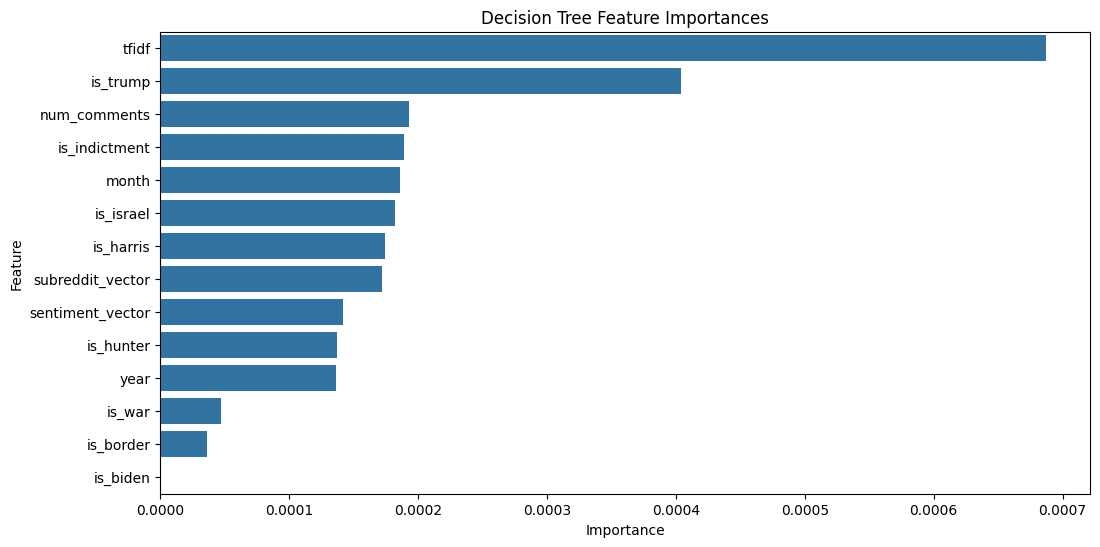

In [144]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.barplot(data=feature_importances, x="importance", y="feature", ax=ax)

plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.show()